# Deep Music Genre

In [1]:
import os
import _pickle as pickle

import IPython
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import optimizers
from keras.utils.vis_utils import model_to_dot
from sklearn.model_selection import train_test_split

from models import resnet, spotify

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Visualizing and preprocessing

We already have the preprocessed songs as melspectograms (see scripts/generate_data.py). Let's load them and see one for each genre.

In [2]:
GTZAN_ROOT = 'datasets/genres'
GTZAN_GENRES = [f for f in os.listdir(GTZAN_ROOT)
                if os.path.isdir(os.path.join(GTZAN_ROOT, f))]
CLASSES = len(GTZAN_GENRES)

In [3]:
with open(os.path.join(GTZAN_ROOT, 'data.pickle'), 'rb') as f:
    X, y = pickle.load(f)
    
print(X.shape)
print(y.shape)

(1000, 647, 128)
(1000, 10)


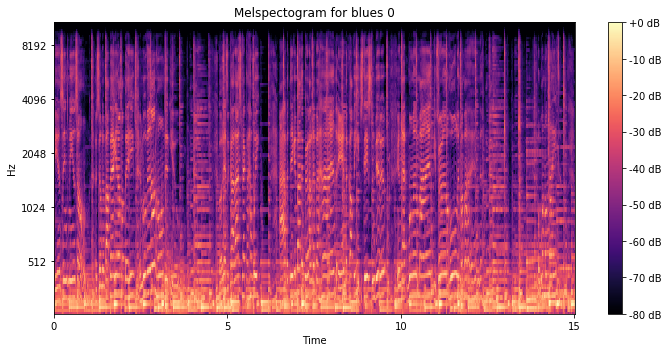

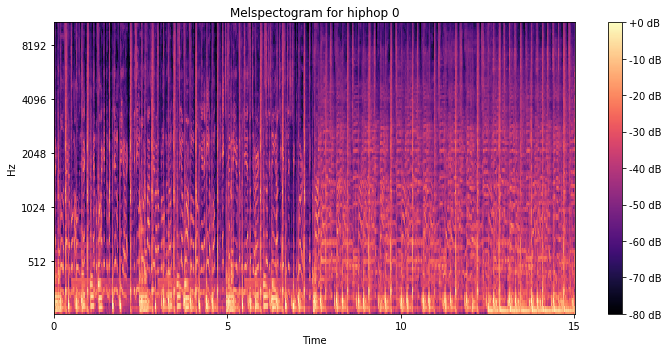

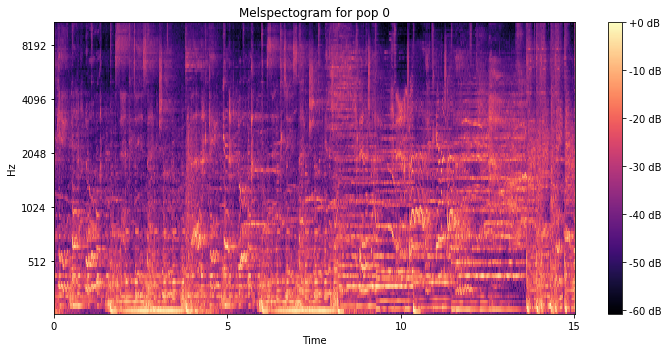

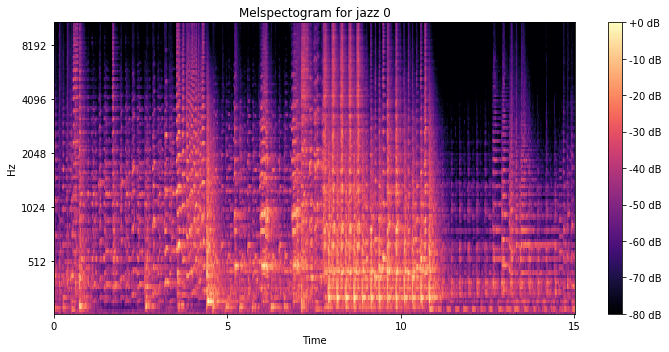

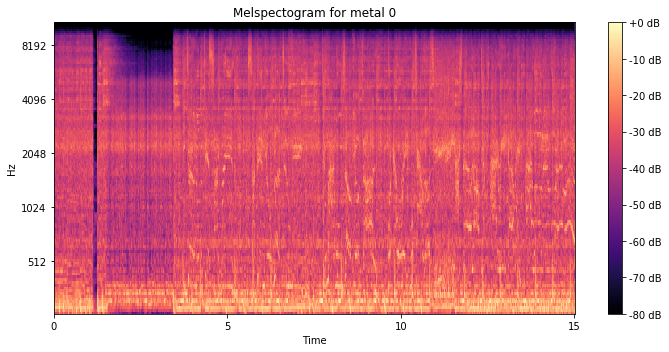

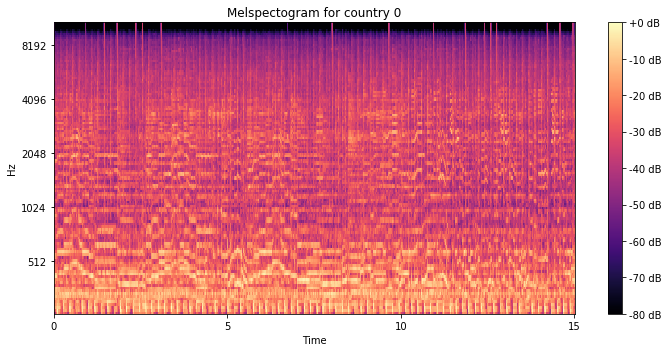

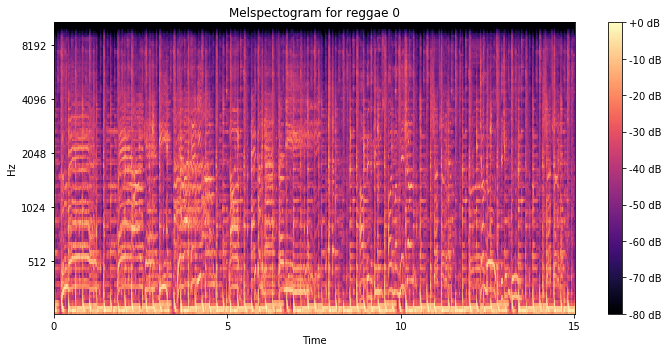

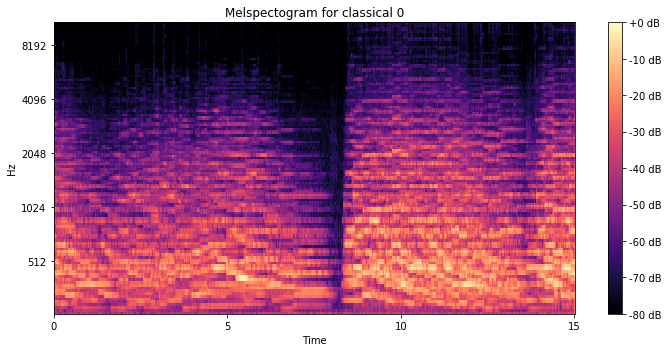

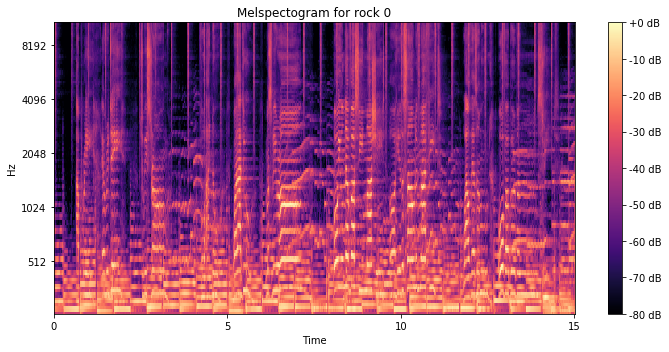

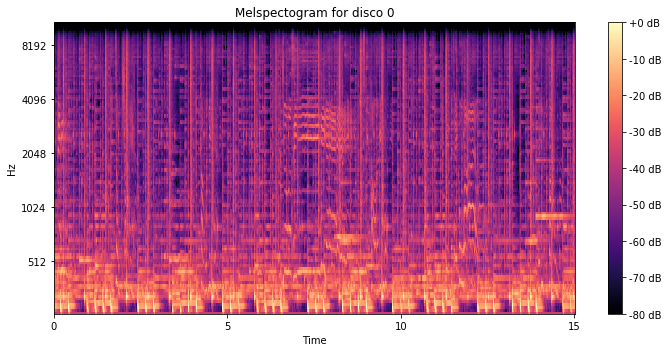

In [4]:
for i, genre in enumerate(GTZAN_GENRES):
    x = X[i*100, :, :]
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(x.T, y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Melspectogram for ' + genre + ' 0')
    plt.tight_layout()

Let's split the data into validation, test and train sets. Then we'll also shuffle it.

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.33, random_state=42)

print('TRAIN: X = {0}, y = {1}'.format(X_train.shape, y_train.shape))
print('TEST: X = {0}, y = {1}'.format(y_val.shape, y_val.shape))

TRAIN: X = (670, 647, 128), y = (670, 10)
TEST: X = (330, 10), y = (330, 10)


Now let's center the data around the mean, and split it into test, train and validation sets.

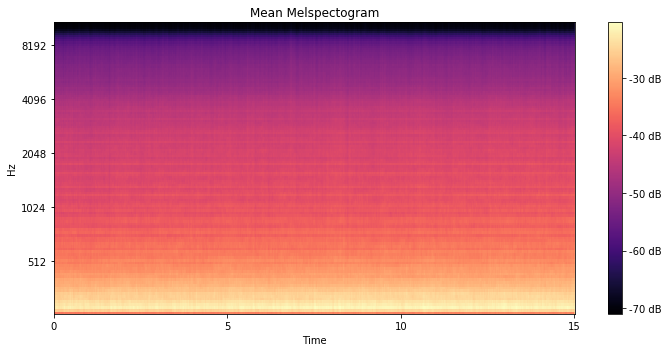

In [6]:
mean_spectogram = np.mean(X_train, axis=0)
plt.figure(figsize=(10, 5))
librosa.display.specshow(mean_spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mean Melspectogram')
plt.tight_layout()

In [7]:
std_spectogram = np.std(X_train, axis=0)
X_val = (X_val - mean_spectogram) / std_spectogram
X_train = (X_train - mean_spectogram) / std_spectogram

## Training the model

We'll be using a Resnet model with 5 Identity residual units per residual block (as described in [Identity Mappings in Deep Residual Networks](https://arxiv.org/pdf/1603.05027.pdf)).

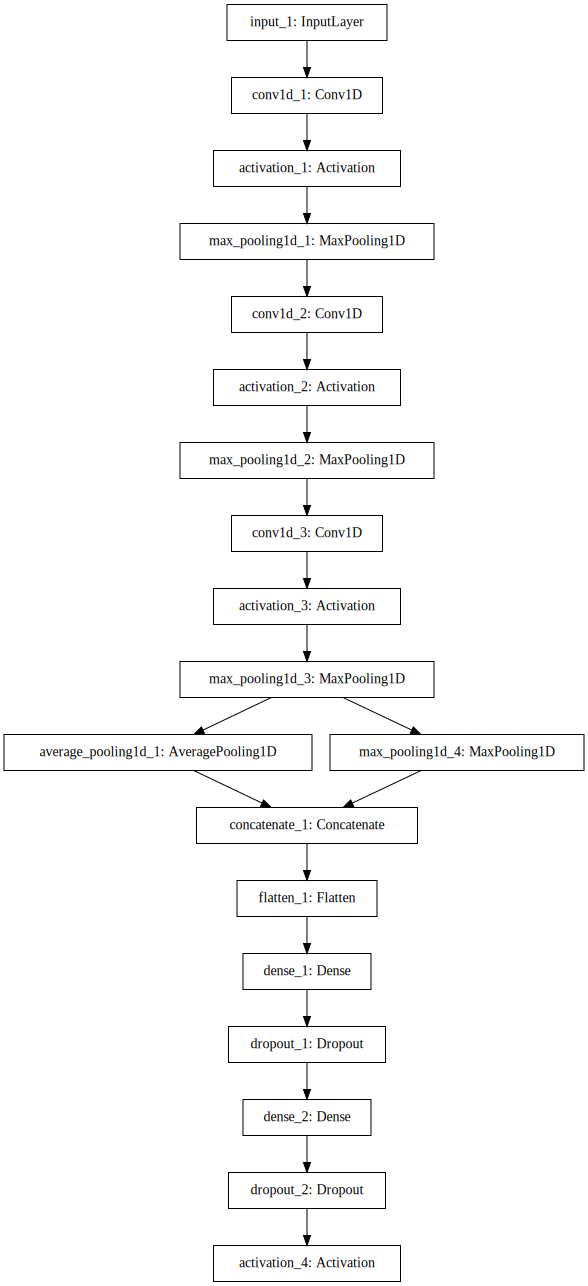

In [8]:
#model = resnet.get(X_train[0].shape, CLASSES, resnet.IdentityResidualUnit, [2,2,2])
#X_train = X_train.reshape(X_train.shape + (1,))
#X_val = X_val.reshape(X_val.shape + (1,))
model = spotify.get(X_train[0].shape, CLASSES)
IPython.display.SVG(model_to_dot(model).create(prog='dot', format='svg'))

Now let's train our model using Adam.

In [9]:
BATCH_SIZE = 32
EPOCHS = 50

optimizer = optimizers.Adam(lr=0.001, decay=0.01)
with tf.device('/gpu:0'):
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])
    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        verbose=1)

Train on 670 samples, validate on 330 samples
Epoch 1/50
670/670 [==============================] - 3s - loss: 2.2376 - acc: 0.1701 - val_loss: 2.1326 - val_acc: 0.1758
Epoch 2/50
670/670 [==============================] - 4s - loss: 2.1670 - acc: 0.1821 - val_loss: 2.0976 - val_acc: 0.1636
Epoch 3/50
670/670 [==============================] - 4s - loss: 2.0695 - acc: 0.2119 - val_loss: 1.9352 - val_acc: 0.2424
Epoch 4/50
670/670 [==============================] - 4s - loss: 2.0484 - acc: 0.2179 - val_loss: 1.8820 - val_acc: 0.2758
Epoch 5/50
670/670 [==============================] - 4s - loss: 1.9819 - acc: 0.2672 - val_loss: 1.8222 - val_acc: 0.3455
Epoch 6/50
670/670 [==============================] - 4s - loss: 1.9167 - acc: 0.2940 - val_loss: 1.7490 - val_acc: 0.4121
Epoch 7/50
670/670 [==============================] - 4s - loss: 1.8294 - acc: 0.3209 - val_loss: 1.6636 - val_acc: 0.3788
Epoch 8/50
670/670 [==============================] - 4s - loss: 1.8243 - acc: 0.3388 - val_l

dict_keys(['val_acc', 'val_loss', 'loss', 'acc'])


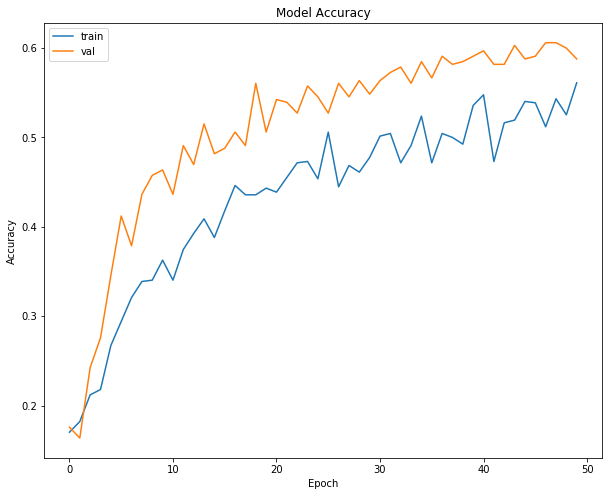

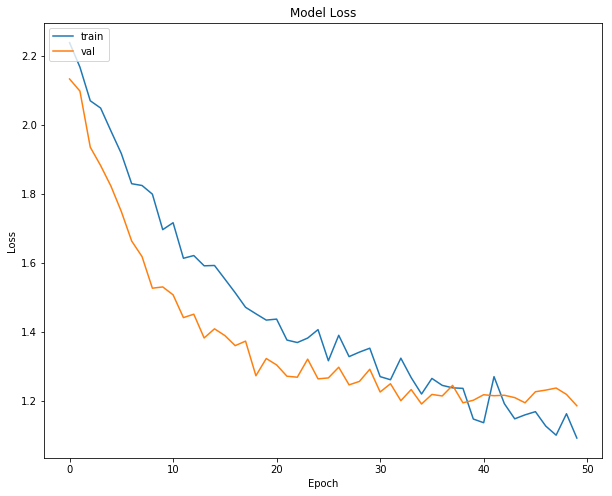

In [10]:
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()